In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cartesian = np.load('../data/benchmark_cartesian.npy')
polar = np.load('../data/benchmark_polar.npy')
print(cartesian.shape)

(9,)


In [4]:
n_points = 9
n_pix_pupils = np.logspace(5, 13, n_points, base=2)

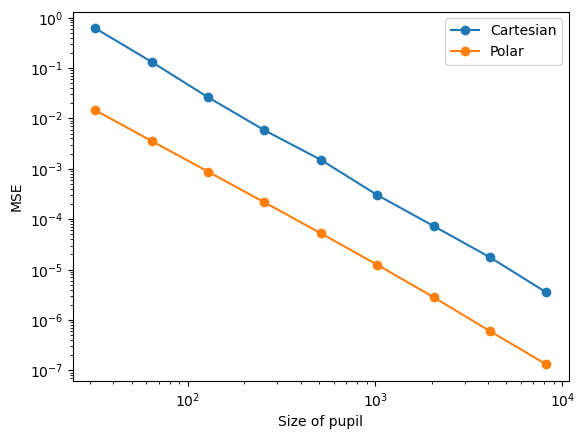

In [12]:
plt.loglog(n_pix_pupils, cartesian, label='Cartesian', marker='o')
plt.loglog(n_pix_pupils, polar, label='Polar', marker='o')
plt.xlabel('Size of pupil')
plt.ylabel('MSE')
plt.legend()
plt.show()